In [2]:
#TESTE PARA COMPROVAÇÃO E USO DE GAN'S EM IMAGENS PARA AUMENTO DE DADOS

#REFERÊNCIAS

#MATPLOTLIB - PLOT DE VÁRIAS IMAGENS - https://www.delftstack.com/pt/howto/matplotlib/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/ --- https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib


In [3]:
#BIBLIOTECA PLOT

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#BIBLIOTECA GAN'S

import tensorflow as tf
from tensorflow.keras.layers import (Dense,BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose,Conv2D, Dropout,Flatten)

In [5]:
#Importando imagens de números
#train_images = base de imagens
#train_labels = targets dessas imagens

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 
len(train_images)

60000

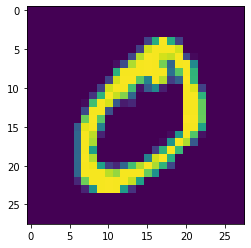

In [6]:
plt.imshow(train_images[1])

In [7]:
train_images[1].shape

(28, 28)

In [8]:
train_3 = train_images[train_labels == 3]

In [9]:
train_images = train_3
type(train_images)

numpy.ndarray

In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-03-02 15:22:07.606687: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 15:22:07.612681: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


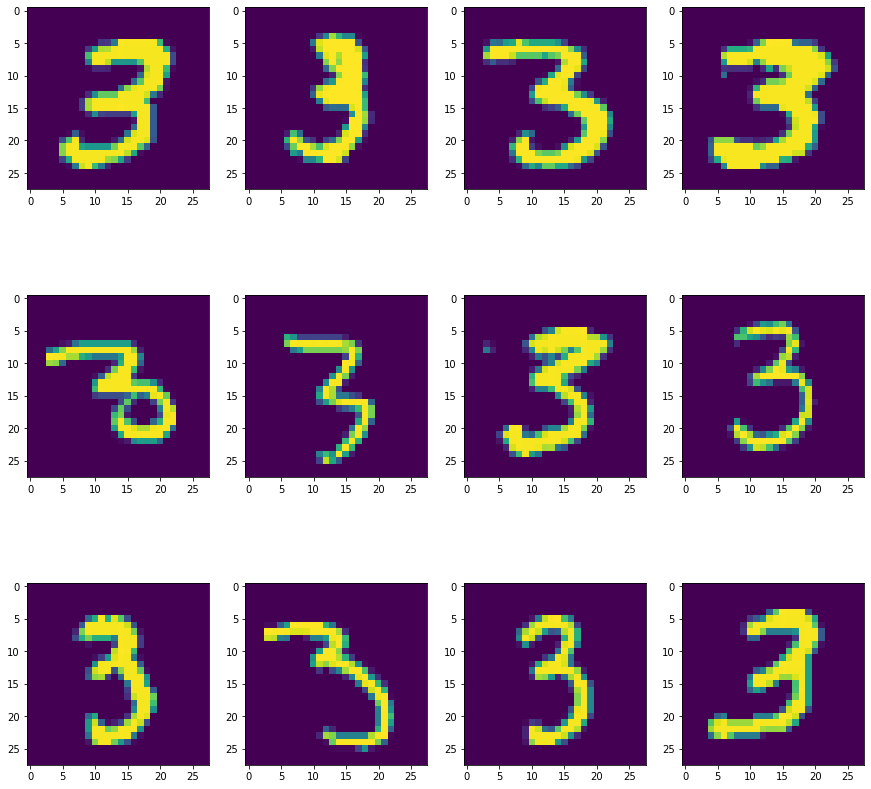

In [11]:
#Plotando as imagens acima baixadas

plt.figure(figsize=(15,15)) # specifying the overall grid size

for i in range(12):
    plt.subplot(3,4,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(train_images[i])
    

plt.show()

In [12]:
#GAN'S
#PARÂMETROS DA REDE NEURAL GERADOR

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

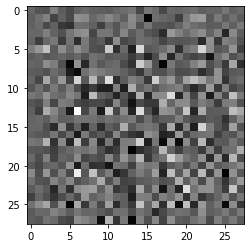

In [44]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [45]:
#PARÂMETROS DA REDE NEURAL DISCRIMINADOR

def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [46]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00064006]], shape=(1, 1), dtype=float32)


In [47]:
#FUNÇÕES DE PERDA E OTIMIZADORES
#AS FUNÇÕES DE PERDA NOS MOSTRAM O QUÃO BOM O GERADOR ESTÁ EM ENGANAR O DISCRIMINADOR

#EXAMPLE LOSSES.BINARYCROSSENTROPY
#y_true = [0, 1, 0, 0]
#y_pred = [-18.6, 0.51, 2.94, -12.8]
#bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#bce(y_true, y_pred).numpy()
#OutPut: 0.865

#TF.ONES_LIKE = TRANSFORMA TODOS OS ELEMENTOS DO TENSOR IGUAL À 1
#TF.ZEROS_LIKE = TRANSFORMA TODOS OS ELEMENTOS DO TENSOR IGUAL À 0

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [48]:
#Salvando nosso processo a cada época

import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [49]:
#Train model - GAN's

EPOCHS = 10
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate,noise_dim])
gen_error = []
disc_error = []

# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      gen_error.append(gen_loss)
      disc_error.append(disc_loss)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))

    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [50]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    # display.clear_output(wait=True)
    # generate_and_save_images(generator,
    #                          epoch + 1,
    #                          seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    # if (epoch + 1) % 5 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  imgnova = generate_and_save_images(generator,
                           epochs,
                           seed)
  return imgnova

In [51]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return predictions

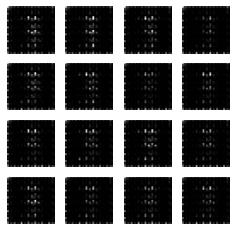

In [52]:
imgnv = train(train_dataset,EPOCHS)

In [64]:
#Salvando o treinamento do Gerador

generator.save('generatorMnist')

INFO:tensorflow:Assets written to: generatorMnist/assets


In [65]:
from tensorflow import keras

model = keras.models.load_model('generatorMnist')

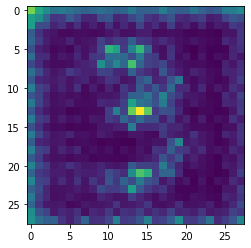

In [ ]:
plt.imshow(imgnv[11])

In [ ]:
#Adicionando as imagens geradas dentro da lista criada

listaumentada = []

for i in train_images:
    # listaumentada = listaumentada.append(train_images)
    listaumentada.append(i)

for i in imgnv:
    listaumentada.append(i)


In [ ]:
len(listaumentada)

6147

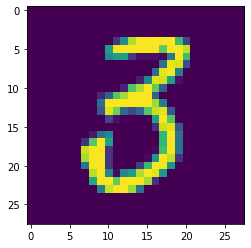

In [ ]:
plt.imshow(listaumentada[3000])